In [90]:
# Definiamo le librerie da usare
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

In [3]:
# Inizializziamo il dataset 
dataset = pd.read_csv('venezia.csv', index_col=False)
# Andiamo a valutare solo i dati ottenuti nel 2015
dataset_2015 = dataset[pd.DatetimeIndex(dataset["datetime"]).year == 2015]
dataset_2015 = dataset_2015.set_index(pd.DatetimeIndex(dataset_2015['datetime']))
dataset_2015 = dataset_2015.drop(['datetime'], axis=1)

In [4]:

# Inizializziamo il dataset delle rilevazione metereologiche
dataset_meteo = pd.read_csv('meteos.csv')

# Andiamo a Normalizzare e scomporre le informazioni correltate alla data di acquisizione
dataset_meteo['HR'] = np.where(dataset_meteo['HR'] >= 10 , dataset_meteo['HR'],"0"+dataset_meteo['HR'].astype("string"))
dataset_meteo['MO']= np.where(dataset_meteo['MO'] >= 10 , dataset_meteo['MO'],"0"+dataset_meteo['MO'].astype("string"))
dataset_meteo['DY'] = np.where(dataset_meteo['DY'] >= 10 , dataset_meteo['DY'],"0"+dataset_meteo['DY'].astype("string"))

# Ricompattiamo i dati una volta normalizzati
dataset_meteo['time'] =  dataset_meteo['HR'].astype("string") + ':' + '00' + ':' + '00'
dataset_meteo['date'] =  dataset_meteo['YEAR'].astype("string") + '-' + dataset_meteo['MO'].astype("string") + '-' + dataset_meteo['DY'].astype("string")

# Rigenereiamo la data seguendo il formato specifico e la impostiamo come indice
format = '%Y-%m-%d %H:%M:%S'
dataset_meteo['Datetime'] = pd.to_datetime(dataset_meteo['date'] + ' ' + dataset_meteo['time'], format=format)
dataset_meteo = dataset_meteo.set_index(pd.DatetimeIndex(dataset_meteo['Datetime']))

# Eliminiamo le colonne usate in fase di sviluppo e Normalizziamo la colonna delle temperature
dataset_meteo = dataset_meteo.drop(['YEAR','MO','DY','HR','time','date','Datetime'], axis=1)
dataset_meteo = dataset_meteo.rename(columns= {'T2M;':'temperature'})
dataset_meteo["temperature"] = dataset_meteo["temperature"].apply(lambda x: float(x.replace(';','')))

In [5]:
# Generiamo il dataset Finale Dato dal merge dei due Dataframe 
## Il risultato comprenderà unicamente 3 mesi per via dei dati mancanti 
dataset_finale = dataset_2015.join(dataset_meteo).dropna()

In [6]:
# Andiamo a generare una colonna dedita al conteggio delle settimane 
dataset_finale["week"] = dataset_finale.index.isocalendar().week

In [7]:
# Generiamo un datafame contenente le medie settimanali
andamento_settimanale = dataset_finale.groupby("week").mean()

In [8]:
andamento_settimanale.mean()

level          31.591772
temperature     7.598224
dtype: float64

In [9]:
andamento_settimanale.max()

level          66.785714
temperature    12.728367
dtype: float64

In [10]:
andamento_settimanale.min()

level          15.202381
temperature     4.216548
dtype: float64

In [227]:
# generiamo la funzione per l'interpolazione

def interpolation(x):
    xm = andamento_settimanale["temperature"].mean() # media x
    ym = andamento_settimanale["level"].mean() # media y
    vm = andamento_settimanale["temperature"] - xm # vettore x - media x
    vym = andamento_settimanale["level"] - ym # vettore y - media y
    mol = vm * vym
    res_sum_mol = mol.sum()
    v_seconda = vm * vm
    res_2 = v_seconda.sum()
    risultato = res_sum_mol / res_2
    p1 = (risultato * -xm) + ym
    result = (x * risultato) + p1
    return result 
    
result = [{"level":2,"temperature":interpolation(2)},{"level":13,"temperature":interpolation(13)}]
andamento_settimanale_fallato = andamento_settimanale.copy()
result

[{'level': 2, 'temperature': 35.69924368972168},
 {'level': 13, 'temperature': 27.628435459805438}]

In [206]:
for x in range(1,15):
    andamento_settimanale_fallato = andamento_settimanale_fallato.drop(x)

In [209]:
andamento_settimanale_fallato = andamento_settimanale_fallato.append(result[0],ignore_index=True)
andamento_settimanale_fallato = andamento_settimanale_fallato.append(result[1],ignore_index=True)

<AxesSubplot:xlabel='temperature', ylabel='level'>

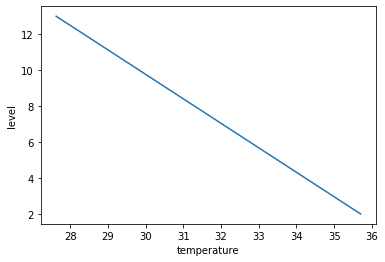

In [212]:
sns.lineplot(data=andamento_settimanale_fallato,x="temperature",y="level")

<AxesSubplot:xlabel='temperature', ylabel='level'>

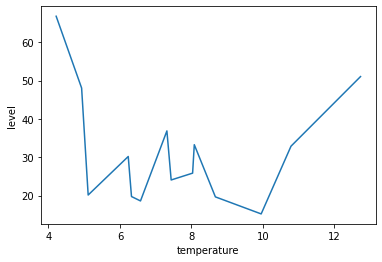

In [11]:
sns.lineplot(data=andamento_settimanale,x="temperature",y="level")

In [12]:
# Ora simuliamo che per via di qualche problema vadano persi dei dati
andamento_settimanale_fallato = andamento_settimanale.copy()
andamento_settimanale_fallato.iloc[11] = [np.nan,np.nan]
andamento_settimanale_fallato.iloc[3] = [np.nan,np.nan]
andamento_settimanale_fallato.iloc[6] = [np.nan,np.nan]
andamento_settimanale_fallato = andamento_settimanale_fallato.astype({"level": float}, errors='raise') 
andamento_settimanale_fallato = andamento_settimanale_fallato.astype({"temperature": float}, errors='raise')

<AxesSubplot:xlabel='temperature', ylabel='level'>

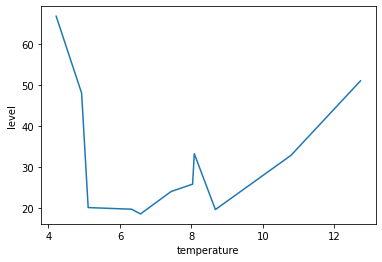

In [13]:
sns.lineplot(data=andamento_settimanale_fallato,x="temperature",y="level")

In [14]:
# Grazie all'interpolazione possiamo riuscire tramite l'utilizzo dei dati conosciuti a risalire quelli persi
andamento_settimanale_recuperato = andamento_settimanale_fallato.interpolate()

<AxesSubplot:xlabel='temperature', ylabel='level'>

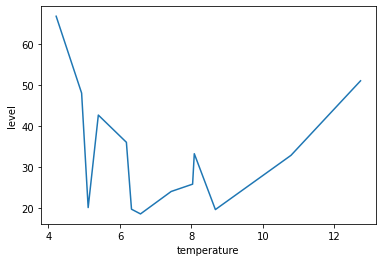

In [15]:
sns.lineplot(data=andamento_settimanale_recuperato,x="temperature",y="level")

28.362145298888734